## Importing Libraries

In [ ]:
import re
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

## Loading Pre-trained Model

In [ ]:
# http://vectors.nlpl.eu/repository/

!wget http://vectors.nlpl.eu/repository/20/40.zip -O '/tmp/word2vec.zip'

--2020-10-23 12:53:44--  http://vectors.nlpl.eu/repository/20/40.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3033545498 (2.8G) [application/zip]
Saving to: ‘/tmp/word2vec.zip’

/tmp/word2vec.zip   100%[===================>]   2.83G  17.5MB/s    in 2m 57s  

2020-10-23 12:56:42 (16.3 MB/s) - ‘/tmp/word2vec.zip’ saved [3033545498/3033545498]



## Extracting Data from Model

In [ ]:
local_training_zip = '/tmp/word2vec.zip'
if zipfile.is_zipfile(local_training_zip):
    zip_ref = zipfile.ZipFile(file=local_training_zip, mode='r')
    zip_ref.extractall('/tmp/')
    zip_ref.close()

In [ ]:
embeddings_index = {}
flag = True
with open('/tmp/model.txt') as f:
    try:
        for line in f:
            if flag:
                flag = False
            else:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    except Exception as e:
        print(e)

'utf-8' codec can't decode byte 0xd1 in position 681: invalid continuation byte


In [ ]:
print('No. of distinct words embeddings:', len(embeddings_index))

embedding_dim = len(list(embeddings_index.values())[0])
print('Length of a embedding:', embedding_dim)

No. of distinct words embeddings: 422146
Length of a embedding: 100


## Loading Dataset

In [ ]:
df = pd.read_csv(filepath_or_buffer='classified_titles.tsv', sep='\t')
df

,Position,Classification
0,Lead Back-end Engineer,Technical
1,Professor of Iron Metallurgy,Other
2,Product and Business Development Manager (MBA ...,Other
3,Co-Founder and Initiator,Business
4,Recruiter & CEO/CTO,Other
...,...,...
995,"Product Manager, Sales Engineer",Sales-Marketing
996,Researcher and Partner,Technical
997,Chief Advocate for Business Growth,Business
998,Head of Digital Marketing and Brand Strategy,Sales-Marketing


## Pre-processing Data

In [ ]:
for i in range(df.shape[0]):
    tmp1 = re.sub('&', 'and', df['Position'][i])
    tmp2 = re.sub(r'[^a-zA-Z ]', ' ', tmp1)
    df['Position'][i] = re.sub(r'  +', ' ', tmp2)
df

,Position,Classification
0,Lead Back end Engineer,Technical
1,Professor of Iron Metallurgy,Other
2,Product and Business Development Manager MBA I...,Other
3,Co Founder and Initiator,Business
4,Recruiter and CEO CTO,Other
...,...,...
995,Product Manager Sales Engineer,Sales-Marketing
996,Researcher and Partner,Technical
997,Chief Advocate for Business Growth,Business
998,Head of Digital Marketing and Brand Strategy,Sales-Marketing


In [ ]:
N = 16

dct = {i:0 for i in range(N)}
for i in range(df.shape[0]):
    tmp = len(df['Position'][i].split())
    dct[tmp] += 1

In [ ]:
dct

{0: 0,
 1: 11,
 2: 92,
 3: 213,
 4: 217,
 5: 191,
 6: 127,
 7: 76,
 8: 29,
 9: 12,
 10: 9,
 11: 3,
 12: 8,
 13: 7,
 14: 4,
 15: 1}

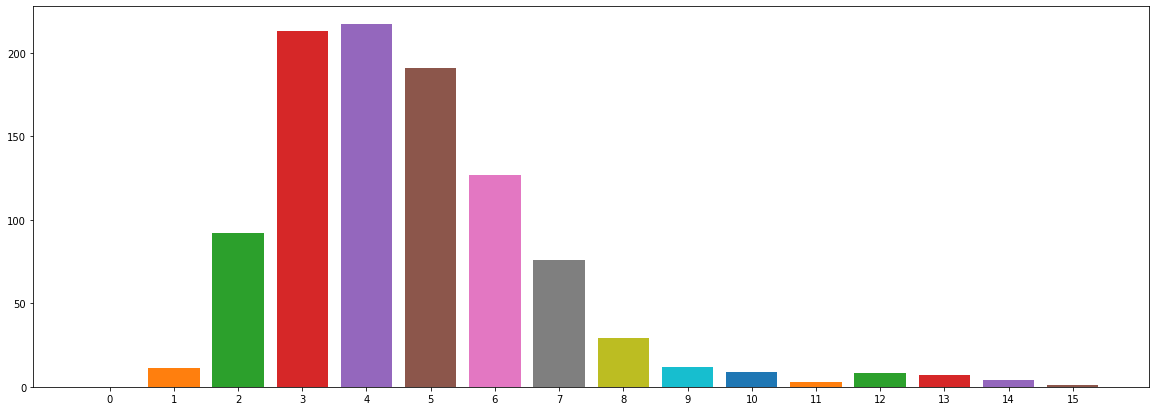

In [ ]:
plt.figure(figsize=(20, 7))
plt.xticks(ticks=[i for i in range(N)])
for i in range(N):
    plt.bar(x=i, height=dct[i])

In [ ]:
MX_LN = 6

new_dct = {'Position': [], 'Classification': []}
for i in range(df.shape[0]):
    tmp = len(df['Position'][i].split())
    if (tmp <= MX_LN):
        new_dct['Position'].append(df['Position'][i])
        new_dct['Classification'].append(df['Classification'][i])

In [ ]:
pd.DataFrame(data=new_dct)

,Position,Classification
0,Lead Back end Engineer,Technical
1,Professor of Iron Metallurgy,Other
2,Co Founder and Initiator,Business
3,Recruiter and CEO CTO,Other
4,Brand Manager Product Development,Sales-Marketing
...,...,...
846,Chief Executive Officer RealBiz Media,Business
847,Product Manager Sales Engineer,Sales-Marketing
848,Researcher and Partner,Technical
849,Chief Advocate for Business Growth,Business


In [ ]:
categorical_data = pd.Categorical(values=df['Classification'])

classes = categorical_data.categories
classes

Index(['Business', 'Other', 'Sales-Marketing', 'Technical'], dtype='object')

In [ ]:
df['Classification'] = list(map(int, categorical_data.codes))
df

,Position,Classification
0,Lead Back end Engineer,3
1,Professor of Iron Metallurgy,1
2,Product and Business Development Manager MBA I...,1
3,Co Founder and Initiator,0
4,Recruiter and CEO CTO,1
...,...,...
995,Product Manager Sales Engineer,2
996,Researcher and Partner,3
997,Chief Advocate for Business Growth,0
998,Head of Digital Marketing and Brand Strategy,2


In [ ]:
# Example to retrieve original classification class
pd.Categorical.from_codes(codes=[2, 1, 0], categories=categorical_data.categories)

['Sales-Marketing', 'Other', 'Business']
Categories (4, object): ['Business', 'Other', 'Sales-Marketing', 'Technical']

## Tokenizing

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=None,
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None
)
tokenizer.fit_on_texts(texts=df['Position'])

In [ ]:
word_index = tokenizer.word_index
word_index

{'a': 265,
 'aandr': 616,
 'ab': 796,
 'aberdeen': 486,
 'accelerator': 774,
 'account': 111,
 'accountant': 175,
 'accounting': 125,
 'accounts': 220,
 'acquired': 283,
 'acquisition': 595,
 'acquisitions': 334,
 'action': 530,
 'admin': 381,
 'administration': 245,
 'administrativo': 967,
 'administrator': 187,
 'advanced': 822,
 'advertising': 603,
 'advice': 713,
 'advisor': 68,
 'advisory': 66,
 'advocate': 337,
 'aerospace': 915,
 'affairs': 120,
 'affiliate': 785,
 'affiliates': 816,
 'ag': 470,
 'ai': 171,
 'alcon': 699,
 'alexa': 445,
 'algorithm': 793,
 'alliance': 918,
 'alliances': 955,
 'alumni': 425,
 'amap': 869,
 'ambassador': 896,
 'america': 165,
 'american': 489,
 'americas': 285,
 'analysis': 126,
 'analyst': 51,
 'analytical': 384,
 'analytics': 244,
 'ancestry': 803,
 'and': 1,
 'andreessen': 481,
 'android': 329,
 'animal': 606,
 'apac': 286,
 'api': 577,
 'app': 747,
 'application': 274,
 'applications': 179,
 'applied': 596,
 'architect': 59,
 'architectural': 

In [ ]:
vocab_size = len(word_index)
print('No. of words:', vocab_size)

No. of words: 980


In [ ]:
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'

sequences = tokenizer.texts_to_sequences(texts=df['Position'])
padded_seq = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MX_LN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

In [ ]:
padded_seq

array([[ 26, 203, 204,  36,   0,   0],
       [ 44,   2, 361, 362,   0,   0],
       [ 15,   1,  19,   9,   5, 363],
       ...,
       [ 10, 337,  33,  19,  99,   0],
       [  7,   2,  35,  13,   1,  78],
       [ 57,  48, 177,  32, 351,   0]], dtype=int32)

## Building Embedding Matrix

In [ ]:
# we are adding 1 to vocab_size for oov_token as we don't included in our Tokenizer
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))

dct = list(word_index.items())[:vocab_size]
for word, i in dct:
    embedding_vector = embeddings_index.get(word)

    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector
    else:
        print(word)

randd
controllership
comotion
finop
galenics
zmt
mjml
mailjet
icdac
eaes
monacotech
poweroasis
installtion
founderandchief
swfte
brandlab
partener
srate
foodninja
softwa
directcors
aandr
courtlink
founderandceo
greenonyx
rusnano
westburne
faunder
emss
cereality
investro
psikolojik
maanger
emear
egineering
humanizer
producting
swqa
exexecutive
geneinsight
iomedia
reactjs
joiz
lexity
equippo
pandc
cadete
realbiz


In [ ]:
embeddings_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.29169999e-02, -7.22360015e-02,  1.53871998e-01, ...,
        -4.09000000e-04,  2.49518007e-01, -1.95117995e-01],
       [ 6.83599990e-03, -2.70947009e-01,  3.13385993e-01, ...,
        -2.46483997e-01,  3.43903989e-01, -3.84059995e-01],
       ...,
       [-3.45218003e-01, -3.70469004e-01,  5.29999994e-02, ...,
         4.79424000e-01, -7.88802028e-01,  6.70566022e-01],
       [-2.03951001e-01, -2.37712994e-01,  1.75675005e-01, ...,
         9.58052993e-01, -4.76852000e-01,  5.59110999e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:
embeddings_matrix.shape

(981, 100)

## Defining Model

In [ ]:
model = tf.keras.Sequential(layers=[
    tf.keras.layers.Embedding(input_dim=(vocab_size+1), output_dim=embedding_dim, input_length=MX_LN, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.LSTM(units=16, activation='tanh', dropout=0.1),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=len(classes), activation='softmax')
], name='JobCategorizer')
model.summary()

Model: "JobCategorizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 6, 100)            98100     
_________________________________________________________________
lstm_14 (LSTM)               (None, 16)                7488      
_________________________________________________________________
dense_26 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 68        
Total params: 105,928
Trainable params: 7,828
Non-trainable params: 98,100
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

## Training Model

In [ ]:
BATCH_SIZE = 16
NUM_EPOCHS = 50

history = model.fit(
    x=padded_seq,
    y=df['Classification'],
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/50
50/50 [==============================] - 1s 11ms/step - loss: 1.3328 - acc: 0.3887 - val_loss: 1.2959 - val_acc: 0.4150
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 1.2135 - acc: 0.4325 - val_loss: 1.2186 - val_acc: 0.5000
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 1.0840 - acc: 0.5425 - val_loss: 1.0761 - val_acc: 0.5550
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.9657 - acc: 0.6100 - val_loss: 0.9998 - val_acc: 0.6150
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.8933 - acc: 0.6600 - val_loss: 0.9017 - val_acc: 0.6550
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.8259 - acc: 0.6787 - val_loss: 0.8214 - val_acc: 0.6650
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.7662 - acc: 0.7013 - val_loss: 0.7838 - val_acc: 0.6600
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.7030 - acc: 0.7

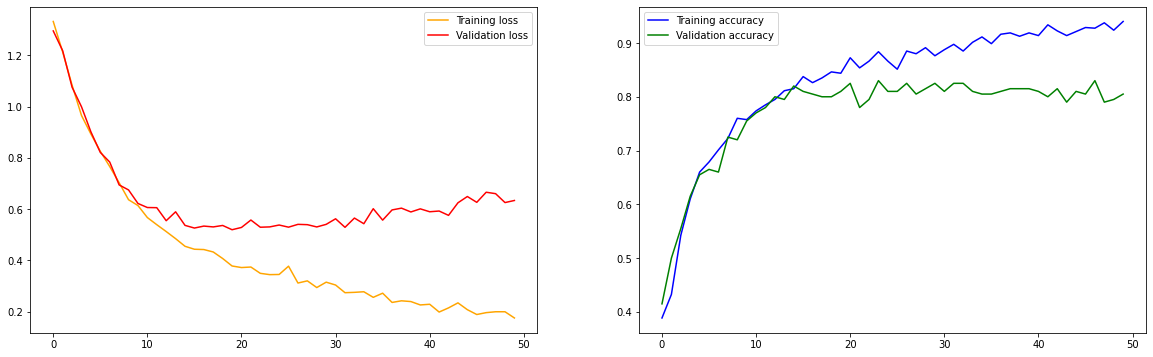

In [ ]:
plt.figure(figsize=(20, 6))
plt.title('Results')

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='orange', label='Training loss')
plt.plot(history.history['val_loss'], color='red', label='Validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], color='blue', label='Training accuracy')
plt.plot(history.history['val_acc'], color='green', label='Validation accuracy')
plt.legend();

## Testing Model

In [222]:
txt = 'Thank you for applying at LoveAlert for Machine Learning engineer position!'

fnd_pttrn = re.search(pattern='[tsop|noitisop|elor](.+?)rof', string=txt[::-1])
if fnd_pttrn:
    test_txt = ' '.join(fnd_pttrn.group()[::-1].strip().split()[1:-1])
    test_seq = tokenizer.texts_to_sequences(texts=[test_txt])
    test_padded_seq = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=MX_LN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)
    prediction = np.argmax(model.predict(x=test_padded_seq), axis=-1)
    print(pd.Categorical.from_codes(codes=prediction, categories=categorical_data.categories)[0])

else:
    print('No role found!')
    # print('Other')

Technical


## Saving Models

In [217]:
import io
import json

# saving tokenizer
tokenizer_json = tokenizer.to_json()
with io.open(file='tokenizer.json', mode='w', encoding='utf-8') as f:
    f.write(json.dumps(obj=tokenizer_json, ensure_ascii=False))

# saving trained model
model.save(filepath='model.h5', overwrite=True, include_optimizer=True)

# saving categories
with open(file='categories.txt', mode='w') as f:
    for category in categorical_data.categories:
        f.write(category + '\n')

## Loading Models

In [239]:
import json

# loading tokenizer
with open(file='tokenizer.json', mode='r') as f:
    data = json.load(fp=f)
    tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(json_string=data)

# loading trained model
model = tf.keras.models.load_model(filepath='model.h5')

# loading categories
ord_categories = []
with open(file='categories.txt', mode='r') as f:
    for line in f:
        ord_categories.append(line[:-1])